## Data Exploration 

## Load Jobs and courses dataset which was scraped
## Clean the datasets
## format the datasets for proper column formatting 
## Lemmatizer and stopwords removal 
## Hierarchical clustering on job titles
## PCA using Word2Vec
## spacy model (en_core_web_sm) and get most common keywords in course description
## spacy model (en_core_web_sm) and get most common keywords in job description
## create-n-grams and tfidfvectorize job description to get most common terms weighted by tfidf 
## cosine similarity between job/course description against skills using tfidf vectorizer
## cosine similarity between job/course description against skills using bert embeddings

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None) 
from os import listdir
import os
import glob
import pandas as pd
import ast 
import numpy as np

In [4]:
## Load the dataset
path = "/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/raw/all_jobs_indeed_first_version"

files= [f for f in listdir(path) if f.endswith(".csv")]
df = pd.concat([pd.read_csv(os.path.join(path,f)) for f in files])



In [7]:
## clean the dataset
columns_of_interest = ['company',
 'companyRating',
 'companyReviewCount',
 'displayTitle',
 'employerAssistEnabled',
 'employerResponsive',
 'extractedSalary',
 'featuredEmployer',
 'featuredEmployerCandidate',
 'formattedLocation',
 'formattedRelativeTime',
 'highVolumeHiringModel',
 'hiringEventJob',
 'indeedApplyEnabled',
 'indeedApplyable',
 'isJobVisited',
 'isMobileThirdPartyApplyable',
 'isNoResumeJob',
 'isSubsidiaryJob',
 'jobCardRequirementsModel',
 'jobLocationCity',
 'jobLocationState',
 'locationCount',
 'newJob',
 'normTitle',
 'openInterviewsInterviewsOnTheSpot',
 'openInterviewsJob',
 'openInterviewsOffersOnTheSpot',
 'openInterviewsPhoneJob',
 'overrideIndeedApplyText',
 'remoteLocation',
 'resumeMatch',
 'salarySnippet',
 'showAttainabilityBadge',
 'showCommutePromo',
 'showEarlyApply',
 'showJobType',
 'showRelativeDate',
 'showSponsoredLabel',
 'showStrongerAppliedLabel',
 'smartFillEnabled',
 'smbD2iEnabled',
 'snippet',
 'sponsored',
 'title',
 'truncatedCompany',
 'urgentlyHiring',
 'vjFeaturedEmployerCandidate',
 'jobDescription']

columns_most_important = ['company',
 'companyRating',
 'companyReviewCount',
 'displayTitle',
 'extractedSalary',
 'salarySnippet',
 'snippet',
 'title',
 'truncatedCompany',
 'jobDescription']

df = df[columns_most_important]


In [8]:


def salary_to_dict(row):
    if pd.isna(row):
        # Return a dictionary with NaN values if the row is NaN
        return {'max': np.nan, 'min': np.nan, 'type': np.nan}
    elif isinstance(row, dict):
        # Return the row as is if it's already a dictionary
        return row
    else:
        # If the row is a string representation of a dictionary (assumed if not NaN or dict),
        # safely evaluate it to a dictionary here
        # Note: Be cautious with `eval`. Here it's mentioned for potential string to dict conversion.
        # In a secure context, confirm the string format and consider `ast.literal_eval` instead.
        try:
            # Convert string to dictionary safely
            dict_row = eval(row)
            return dict_row if isinstance(dict_row, dict) else {'max': np.nan, 'min': np.nan, 'type': np.nan}
        except:
            # In case of error during eval, return NaN values
            return {'max': np.nan, 'min': np.nan, 'type': np.nan}

# Apply the function to each row of the 'extractedSalary' column
salary_dicts = df['extractedSalary'].apply(salary_to_dict)
# Now that we have a series of dictionaries, use `json_normalize` to create a DataFrame
salary_df = pd.json_normalize(salary_dicts)

# Concatenate the new DataFrame with the original one
result_df = pd.concat([df.drop('extractedSalary', axis=1).reset_index(), salary_df], axis=1)

#df["extractedSalary"]=df["extractedSalary"].astype(str)
#df["extractedSalary"]=df['extractedSalary'].apply(ast.literal_eval)




def salary_snippet_to_dict(row):
    if pd.isna(row):
        # Return a dictionary with NaN values if the row is NaN
        return {'currency': np.nan, 'salaryTextFormatted': np.nan, 'source': np.nan,'text':np.nan}
    elif isinstance(row, dict):
        # Return the row as is if it's already a dictionary
        return row
    else:
        # If the row is a string representation of a dictionary (assumed if not NaN or dict),
        # safely evaluate it to a dictionary here
        # Note: Be cautious with `eval`. Here it's mentioned for potential string to dict conversion.
        # In a secure context, confirm the string format and consider `ast.literal_eval` instead.
        try:
            # Convert string to dictionary safely
            dict_row = eval(row)
            return dict_row if isinstance(dict_row, dict) else {'max': np.nan, 'min': np.nan, 'type': np.nan}
        except:
            # In case of error during eval, return NaN values
            return {'currency': np.nan, 'salaryTextFormatted': np.nan, 'source': np.nan,'text':np.nan}

# Apply the function to each row of the 'extractedSalary' column
salary_snippet_dicts = df['salarySnippet'].apply(salary_snippet_to_dict)
# Now that we have a series of dictionaries, use `json_normalize` to create a DataFrame
salary_snippet_df = pd.json_normalize(salary_snippet_dicts)

# Concatenate the new DataFrame with the original one
df = pd.concat([result_df.drop('salarySnippet', axis=1).reset_index(), salary_snippet_df], axis=1)
df = df.drop(columns=["level_0","index"])
#df["extractedSalary"]=df["extractedSalary"].astype(str)
#df["extractedSalary"]=df['extractedSalary'].apply(ast.literal_eval)

## Lemmatizer
## stop words removal

In [15]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Ensure you have the necessary NLTK tokens downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean and lemmatize job title text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)




# Categorize titles based on keywords
def categorize_title(title):
    # Clean and lemmatize the job title
    cleaned_title = clean_text(title)
    
    # Define your category rules
    if 'data engineer' in cleaned_title:
        return 'data engineer'
    elif 'data center' in cleaned_title:
        return 'data center engineer'
    elif (('senior' in cleaned_title) or ('sr' in cleaned_title)) and 'data' in cleaned_title and 'engineer' in cleaned_title:
        return 'senior data engineer'
    # ... add more rules as necessary
    
    return 'Other'  # Default category if no other rule applies

# Apply the categorization function to the 'title' column
df['title'].apply(categorize_title)



[nltk_data] Downloading package punkt to /Users/nyzy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nyzy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/nyzy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       data center engineer
1              data engineer
2              data engineer
3              data engineer
4              data engineer
                ...         
8350                   Other
8351                   Other
8352                   Other
8353                   Other
8354                   Other
Name: title, Length: 8355, dtype: object

## Hierarchical clustering on job titles

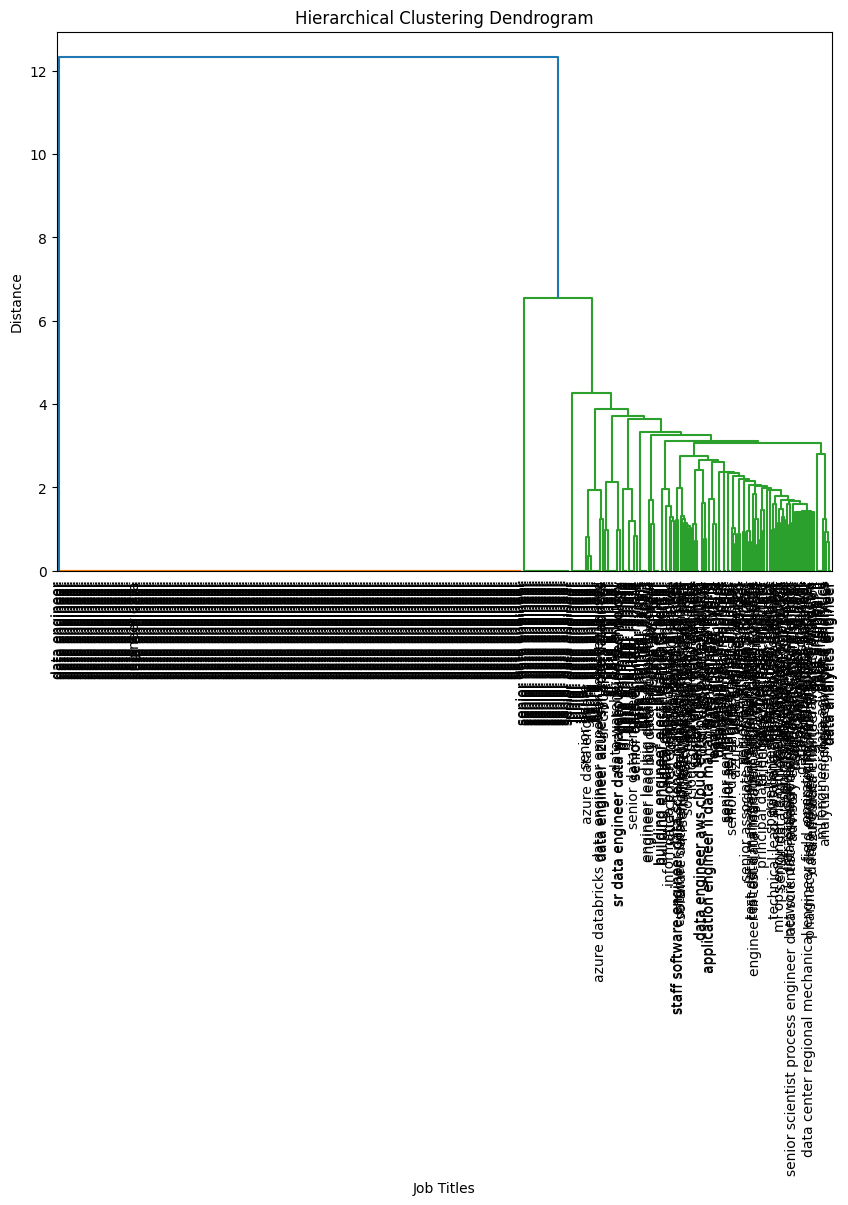

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

df['title'] = df['title'].apply(lambda x:clean_text(x))

# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['title'][:500])

# Hierarchical clustering
Z = linkage(X.toarray(), 'ward')

# Plotting dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df['title'][:500].values, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Job Titles')
plt.ylabel('Distance')
plt.show()


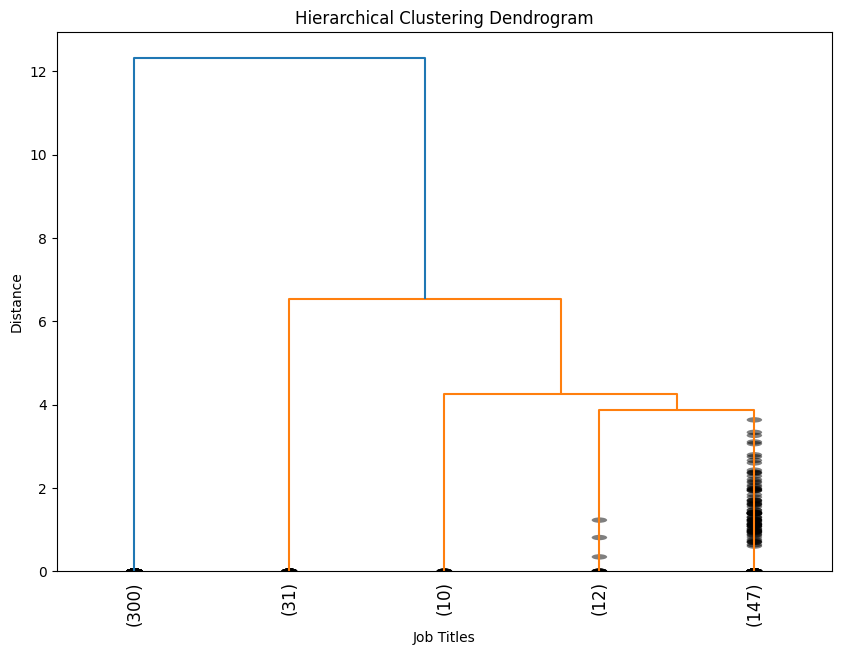

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(10, 7))
# Assuming 'Z' is the linkage matrix obtained from hierarchical clustering
dendrogram(
    Z,
    labels=df['title'][:500].values,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=5,  # show only the last 50 merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Job Titles')
plt.ylabel('Distance')
plt.show()


In [18]:

Z

array([[  0.        , 481.        ,   0.        ,   2.        ],
       [  1.        ,   3.        ,   0.        ,   2.        ],
       [  5.        , 501.        ,   0.        ,   3.        ],
       ...,
       [864.        , 995.        ,   4.25670839, 169.        ],
       [546.        , 996.        ,   6.54087802, 200.        ],
       [851.        , 997.        ,  12.32246421, 500.        ]])

In [175]:
from scipy.cluster.hierarchy import fcluster

# Determine the number of clusters, for example, by setting a threshold
distance_threshold = 2.0
clusters = fcluster(Z, distance_threshold, criterion='distance')
clusters
# Or determine by specifying the exact number of clusters desired
#k = 10
#clusters = fcluster(Z, k, criterion='maxclust')

array([10,  1, 23,  1,  4,  1,  1,  1,  1,  1,  1, 23,  1,  1, 21, 17,  2,
        8, 11,  1, 12,  1,  1,  1,  1,  2,  3,  7, 11, 23,  1,  1,  5,  1,
       25,  4,  1,  1,  1,  1,  2,  1,  1,  1, 10, 10,  1,  1,  1,  1,  1,
        1,  1,  5,  1,  3,  1,  1, 23,  1,  1,  1,  1,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, 10,  1,  8,  1,  1,  1,  1, 25,  1,  1,
        1,  1,  1, 10,  1,  2, 15, 23, 21, 10,  1,  1,  1,  1,  2,  3,  7,
       23,  1, 14,  5,  8,  4,  2,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,
        1, 17,  9, 23,  1,  9, 10,  1, 24, 23,  1, 11,  3,  1,  1, 25, 12,
       11, 15,  1,  4,  1,  2, 23,  7,  1,  1,  1,  1,  1,  1, 23,  1,  1,
        1,  1,  2,  1,  1,  1,  3,  1,  1,  1,  1, 23, 17,  9, 14,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,  1,  1,  2,  1,  9,  2,
       23,  2,  1,  7,  1, 11, 19, 11,  1,  1, 22,  1,  7,  1, 16, 24,  1,
        1,  1,  1, 18,  1,  1,  8,  1,  1,  1,  1,  1,  2,  1,  1,  3,  1,
        1,  1, 14,  1,  7

In [176]:
from collections import Counter

# Assuming you have the following:
# clusters: an array with the cluster labels for each job title
# job_titles: an array with the corresponding job titles

# Create a dictionary where each key is a cluster and the value is a list of titles
clustered_titles = {i: [] for i in range(1, len(set(clusters))+1)}
for title, cluster_label in zip(df['title'].tolist(), clusters):
    clustered_titles[cluster_label].append(title)

# For each cluster, find the most common words
cluster_names = {}
for cluster, titles in clustered_titles.items():
    # Flatten the list of titles into a list of words
    words = " ".join(titles).lower().split()
    # Count the frequency of each word
    word_counts = Counter(words)
    # Remove common stop words (optional, depends on your data)
    for stop_word in [ 'and', 'the', '-']:
        if stop_word in word_counts:
            del word_counts[stop_word]
    # Take the top 3 most common words as the name
    cluster_names[cluster] = ' '.join([word for word, _ in word_counts.most_common(3)])
cluster_names
# Now cluster_names contains a 'name' for each cluster based on the most common words


## PCA using Word2Vec

/var/folders/17/gws30jys63j9xx5l0mwr5r4r0000gq/T/ipykernel_51833/2360709262.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['vector'] = df_new['title'].apply(document_vector)
/Users/nyzy/anaconda3/envs/sandbox/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/17/gws30jys63j9xx5l0mwr5r4r0000gq/T/ipykernel_51833/2360709262.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

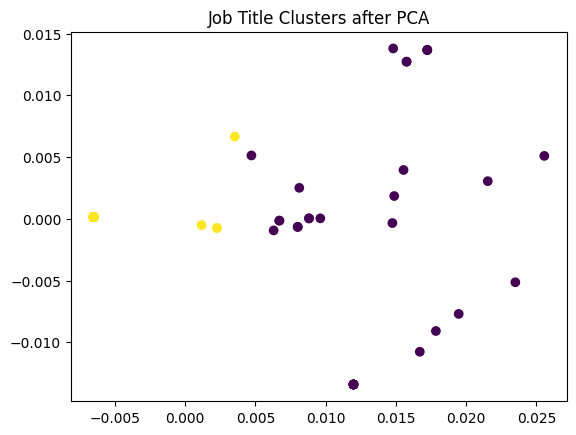

In [149]:
# NLP with clustering 

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

df_new = df[:100]

# Train a Word2Vec model on the job titles
model = Word2Vec(df_new['title'].apply(lambda x: x.split()), min_count=1)

# Convert job titles to vectors
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

df_new['vector'] = df_new['title'].apply(document_vector)

# Fit a PCA or t-SNE to reduce dimensions
pca = PCA(n_components=2)
result = pca.fit_transform(list(df_new['vector']))

# Alternative: t-SNE for a more detailed plot
# tsne = TSNE(n_components=2, verbose=1)
# result = tsne.fit_transform(list(df['vector']))

# KMeans clustering
kmeans = KMeans(n_clusters=2)
df_new['cluster'] = kmeans.fit_predict(result)

# Plot the clusters
plt.scatter(result[:, 0], result[:, 1], c=df_new['cluster'], cmap='viridis')
plt.title('Job Title Clusters after PCA')
plt.show()


In [21]:
## load course dataset
df_c = pd.read_csv("/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/raw/courses_data/udemy_courses_scrape_2023-11-04-13:54:23.csv")
#df_c["description"]=df_c["description"].apply(lambda x: clean_text(x))


In [1]:

import spacy
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/nyzy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True


## spacy model (en_core_web_sm) and get most common keywords in course description

In [132]:
import spacy
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
df_c["full_description"] = df_c["description"]+df_c["what_you_will_learn_data"]+df_c["objectives"]
df_c["full_description"]=df_c["full_description"].apply(lambda x: clean_text(x))
# Function to filter tokens
def filter_token(token):
    return not (token.is_stop or token.is_punct or token.is_space)




# Initialize a list to store the keywords
keywords = []

# Loop through each job description
for description in df_c['full_description']:
    # Process the text using spaCy
    doc = nlp(description.lower())
    # Filter tokens and get lemmas
    tokens = [token.lemma_ for token in doc if filter_token(token)]
    keywords.extend(tokens)

# Remove NLTK's default stop words
stop_words = set(stopwords.words('english'))
filtered_keywords = [word for word in keywords if word not in stop_words]

# Count frequency of keywords
keyword_freq = Counter(filtered_keywords)

# Get most common terms
most_common_terms = keyword_freq.most_common(100)

print("Most common terms/skills:")
for term in most_common_terms:
    print(term[0], "-", term[1], "occurrences")


Most common terms/skills:
p - 147285 occurrences
li - 47550 occurrences
strong - 46945 occurrences
learn - 25597 occurrences
datum - 20318 occurrences
de - 18938 occurrences
python - 13673 occurrences
machine - 13370 occurrences
course - 13317 occurrences
br - 11796 occurrences
e - 9167 occurrences
model - 9108 occurrences
nbsp - 8182 occurrences
data - 7576 occurrences
ul - 7359 occurrences
r - 6970 occurrences
science - 6669 occurrences
learning - 6145 occurrences
use - 6064 occurrences
understand - 4927 occurrences
n - 4874 occurrences
analysis - 4781 occurrences
deep - 4739 occurrences
project - 4711 occurrences
ai - 4643 occurrences
create - 4261 occurrences
build - 3962 occurrences
network - 3926 occurrences
para - 3778 occurrences
algorithm - 3729 occurrences
regression - 3558 occurrences
language - 3519 occurrences
neural - 3341 occurrences
la - 3195 occurrences
code - 3147 occurrences
que - 3119 occurrences
en - 3073 occurrences
real - 3061 occurrences
application - 3008 occur


## spacy model (en_core_web_sm) and get most common keywords in job description

In [134]:
import spacy
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
df["jobDescription"]=df["jobDescription"].apply(lambda x: clean_text(x))
# Function to filter tokens
def filter_token(token):
    return not (token.is_stop or token.is_punct or token.is_space)




# Initialize a list to store the keywords
keywords = []

# Loop through each job description
for description in df['jobDescription']:
    # Process the text using spaCy
    doc = nlp(description.lower())
    # Filter tokens and get lemmas
    tokens = [token.lemma_ for token in doc if filter_token(token)]
    keywords.extend(tokens)

# Remove NLTK's default stop words
stop_words = set(stopwords.words('english'))
filtered_keywords_c = [word for word in keywords if word not in stop_words]

# Count frequency of keywords
keyword_freq_c = Counter(filtered_keywords_c)

# Get most common terms
most_common_terms_c = keyword_freq_c.most_common(100)

print("Most common terms/skills:")
for term in most_common_terms_c:
    print(term[0], "-", term[1], "occurrences")


Most common terms/skills:
datum - 53073 occurrences
experience - 48812 occurrences
work - 39255 occurrences
business - 27394 occurrences
team - 26362 occurrences
data - 21440 occurrences
year - 20705 occurrences
include - 18161 occurrences
skill - 17351 occurrences
system - 16626 occurrences
require - 15351 occurrences
solution - 15280 occurrences
support - 14950 occurrences
develop - 14877 occurrences
technology - 14484 occurrences
design - 13878 occurrences
development - 13750 occurrences
ability - 13668 occurrences
process - 13549 occurrences
learn - 13256 occurrences
provide - 12833 occurrences
model - 12336 occurrences
opportunity - 12280 occurrences
job - 12252 occurrences
requirement - 12186 occurrences
analysis - 11863 occurrences
technical - 11693 occurrences
project - 11676 occurrences
time - 11640 occurrences
pay - 11617 occurrences
employee - 11562 occurrences
management - 11360 occurrences
company - 11183 occurrences
benefit - 10916 occurrences
service - 10732 occurrences


In [52]:
#pd.DataFrame(keyword_freq.most_common(10000)).to_csv("/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/Datasets/common_tf_course.csv")



## create-n-grams and tfidfvectorize job description to get most common terms weighted by tfidf 

In [44]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
# nltk.download('stopwords')
#df["jobDescription"]=df["jobDescription"].apply(lambda x: clean_text(x))
df_c["full_description"] = df_c["description"]+df_c["what_you_will_learn_data"]+df_c["objectives"]
df_c["full_description"]=df_c["full_description"].apply(lambda x: clean_text(x))
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

# Custom filter to determine what gets processed
def filter_token(token):
    return not (token.is_stop or token.is_punct or token.is_space or token.lower_ in ENGLISH_STOP_WORDS)

# Function to preprocess the text and create n-grams
def preprocess_and_create_ngrams(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if filter_token(token)]
    # Assuming that we're looking for bigrams, you can increase the window size for larger n-grams
    return ['_'.join(tokens[i:i+2]) for i in range(len(tokens)-1)] + tokens

# Initialize TF-IDF Vectorizer with n-gram range from 1 to 3 and our custom tokenizer
tfidf_vectorizer = TfidfVectorizer(analyzer=preprocess_and_create_ngrams, ngram_range=(1, 3))

# Suppose df_c['description'] is a pandas Series with job descriptions
# Apply the vectorizer to the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df_c['full_description'])

# Get feature names to use as an index to locate the most common terms
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum tf-idf scores for each term across all documents
sums = tfidf_matrix.sum(axis=0)

# Connect term to its sums
data = []
for col, term in enumerate(feature_names):
    data.append( (term, sums[0,col]) )

ranking = pd.DataFrame(data, columns=['term','rank'])
ranking = ranking.sort_values('rank', ascending=False)

print("Most common terms/skills weighted by TF-IDF:")
for index, row in ranking.head(100).iterrows():
    print(f"{row['term']} - {row['rank']}")

#ranking.to_csv("/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/Datasets/tfidf_rank_courses.csv")
# Now you have a sorted list of terms/skills weighted by their importance in the corpus.


/Users/nyzy/anaconda3/envs/sandbox/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:541: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Most common terms/skills weighted by TF-IDF:
p - 616.95022125675
li - 285.614106870648
p_p - 236.24880242855517
strong - 235.90766400529557
li_p - 141.68398669085536
p_li - 139.06708013001847
learn - 135.8784643904584
datum - 119.27112939953562
li_li - 118.97267634544966
machine - 90.72892366928338
python - 89.20104001127035
course - 86.09132023347884
br - 77.91678395391826
p_strong - 76.39422351762683
model - 68.9212466254468
strong_p - 68.2772525849785
e - 65.99062288262371
br_p - 65.56029586745889
p_br - 64.77393237391072
machine_learn - 64.59836304319847
nbsp - 62.97000056356932
ai - 58.398086698917275
r - 58.342861678760784
they - 52.13791538750862
science - 50.93778274137812
data - 50.78072428508952
ul - 50.2617975635891
learning - 49.204336922462
use - 43.82073744318092
network - 42.49602750620699
deep - 41.36181860390645
analysis - 40.18813089746904
n - 39.97504703835112
regression - 39.2292818934036
understand - 39.01165902661968
para - 38.44660388484534
neural - 37.9268590470

In [45]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
# nltk.download('stopwords')
df["jobDescription"]=df["jobDescription"].apply(lambda x: clean_text(x))
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

# Custom filter to determine what gets processed
def filter_token(token):
    return not (token.is_stop or token.is_punct or token.is_space or token.lower_ in ENGLISH_STOP_WORDS)

# Function to preprocess the text and create n-grams
def preprocess_and_create_ngrams(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if filter_token(token)]
    # Assuming that we're looking for bigrams, you can increase the window size for larger n-grams
    return ['_'.join(tokens[i:i+2]) for i in range(len(tokens)-1)] + tokens

# Initialize TF-IDF Vectorizer with n-gram range from 1 to 3 and our custom tokenizer
tfidf_vectorizer = TfidfVectorizer(analyzer=preprocess_and_create_ngrams, ngram_range=(1, 3))

# Suppose df_c['description'] is a pandas Series with job descriptions
# Apply the vectorizer to the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['jobDescription'])

# Get feature names to use as an index to locate the most common terms
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum tf-idf scores for each term across all documents
sums = tfidf_matrix.sum(axis=0)

# Connect term to its sums
data = []
for col, term in enumerate(feature_names):
    data.append( (term, sums[0,col]) )

ranking = pd.DataFrame(data, columns=['term','rank'])
ranking = ranking.sort_values('rank', ascending=False)

print("Most common terms/skills weighted by TF-IDF:")
for index, row in ranking.head(100).iterrows():
    print(f"{row['term']} - {row['rank']}")

ranking.to_csv("/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/Datasets/tfidf_rank_jobs_desc.csv")
# Now you have a sorted list of terms/skills weighted by their importance in the corpus.


/Users/nyzy/anaconda3/envs/sandbox/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:541: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Most common terms/skills weighted by TF-IDF:
datum - 380.56880563901484
experience - 309.66404599484764
work - 243.82516057269876
business - 219.60848655416416
data - 186.8819119342297
team - 176.616116647913
year - 155.0753306619181
solution - 132.7994073032054
skill - 130.0411664299749
require - 128.7988212691132
learn - 127.30116520553752
include - 125.55686421711944
model - 125.00336894375434
machine - 123.38402916735899
technology - 119.68436529537836
support - 117.97129754106297
develop - 116.92360518922746
design - 116.29648563447057
development - 113.43562203176621
ability - 113.17897488205116
process - 111.70443735414457
analysis - 111.49301308645741
requirement - 108.78387671485065
project - 107.71964720057099
pay - 107.28778496630036
management - 106.19452733899405
technical - 105.66873652616249
product - 104.07324578495533
research - 103.64840058350032
company - 103.1333862722096
job - 102.47488953275109
employee - 101.67209836519795
insurance - 101.42049750226262
time - 10

In [34]:
tfidf_matrix.shape


# Define a function to get the top terms with the highest TF-IDF score in a document
def get_top_tfidf_terms(row_index, features, tfidf_matrix, top_n=5):
    # Get the row from the TF-IDF matrix corresponding to the document
    row_data = tfidf_matrix.getrow(row_index)
    
    # Sort the scores and get the top n indices
    sorted_items = row_data.toarray().flatten().argsort()[-top_n:]
    
    # Get the feature names by index
    top_terms = features[sorted_items]
    
    # Get the corresponding scores
    top_scores = row_data.toarray().flatten()[sorted_items]
    
    # Combine the terms with their scores
    top_tfidf_terms = list(zip(top_terms, top_scores))
    
    return top_tfidf_terms

# Apply the function to each row in the DataFrame
df_c['top_skills'] = [
    get_top_tfidf_terms(i, feature_names, tfidf_matrix, top_n=5)
    for i in range(tfidf_matrix.shape[0])
]

In [54]:
data

[('aa', 4.114781309862447),
 ('aa_ada', 0.11555780916268049),
 ('aa_bachelor', 0.037042370111541045),
 ('aa_cash', 0.04689209417675356),
 ('aa_degree', 0.1349756060781238),
 ('aa_disability', 0.0492682055855383),
 ('aa_dsa', 0.05323794037885865),
 ('aa_eeo', 0.04478921390988737),
 ('aa_employer', 1.5450398335896616),
 ('aa_eoe', 0.028547027040269415),
 ('aa_experience', 0.03233153016508408),
 ('aa_f', 1.3001287001129789),
 ('aa_li', 0.37034867332820154),
 ('aa_mfdv', 0.061642702398550075),
 ('aa_minority', 0.2595800544555824),
 ('aa_month', 0.04042043255850861),
 ('aa_officer', 0.03747883047053844),
 ('aa_pay', 0.5570702244653672),
 ('aa_policy', 0.042782760464076836),
 ('aa_statement', 0.1512336833125345),
 ('aa_team', 0.04042043255850861),
 ('aa_vet', 0.3992315107478972),
 ('aa_veteran', 0.029177962833659067),
 ('aa_woman', 0.061312338843276644),
 ('aa_year', 0.06095084771834171),
 ('aaa', 1.1993309787516508),
 ('aaa_club', 0.0579404581633103),
 ('aaa_equal', 0.0579404581633103),
 ('

In [ ]:
## load skillsdataset which is scraped
df_s =  pd.read_csv("/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/skills_dataset/skills_df.csv")


## cosine similarity between job/course description against skills using tfidf vectorizer

In [ ]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Let's say you have your job descriptions, course descriptions, and skills
job_descriptions = filtered_keywords # List of job description texts
course_descriptions = filtered_keywords_c # List of course description texts
skills_list = df_s["name"].tolist()
  # List of skills

# Vectorize the descriptions and skills
tfidf_vectorizer = TfidfVectorizer()
descriptions_tfidf = tfidf_vectorizer.fit_transform(job_descriptions + course_descriptions)
skills_tfidf = tfidf_vectorizer.transform(skills_list)

# Calculate cosine similarity and rank skills
def rank_skills_for_description(description_index, descriptions_tfidf, skills_tfidf):
    cosine_similarities = cosine_similarity(descriptions_tfidf[description_index], skills_tfidf)
    
    # Get the top matching skills indices and scores
    top_skill_indices = cosine_similarities.argsort()[0][-N:]  # Replace N with the number of top skills you want
    top_skill_scores = cosine_similarities[0][top_skill_indices]

    # Map indices to skill names
    top_skills = [(skills_list[i], top_skill_scores[i]) for i in top_skill_indices]
    top_skills = sorted(top_skills, key=lambda x: x[1], reverse=True)  # Sort by highest score first

    return top_skills

# Example: Get top 5 skills for the first job description
top_skills_for_first_job = rank_skills_for_description(0, descriptions_tfidf, skills_tfidf)
print(top_skills_for_first_job)
'''


In [137]:
## making sure to clean the dataframes description
df["jobDescription"]=df["jobDescription"].apply(lambda x: clean_text(x))
df_c["full_description"]=df_c["full_description"].apply(lambda x: clean_text(x))
#df["jobDescription"]=df["jobDescription"].apply(preprocess_text)
#df_c["full_description"]=df_c["full_description"].apply(preprocess_text)


In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Let's say you have your job descriptions, course descriptions, and skills
job_descriptions = df["jobDescription"].tolist() # List of job description texts
course_descriptions = df_c["full_description"].tolist() # List of course description texts
skills_list = df_s[df_s["category"]=="Specialized Skill"]["name"].tolist()  # List of skills

# Combine job descriptions and course descriptions
all_descriptions = job_descriptions + course_descriptions

# Vectorize the descriptions and skills
tfidf_vectorizer = TfidfVectorizer()
all_descriptions_tfidf = tfidf_vectorizer.fit_transform(all_descriptions)

# Transform skills with the same vectorizer
skills_tfidf = tfidf_vectorizer.transform(skills_list)

# Calculate cosine similarity and rank skills
def rank_skills_for_description(description_tfidf, skills_tfidf):
    cosine_similarities = cosine_similarity(description_tfidf, skills_tfidf).flatten()
    
    # Get the top matching skills indices and scores
    top_skills_indices = cosine_similarities.argsort()[::-1]
    
    # Map indices to skill names and scores
    top_skills = [(skills_list[i], cosine_similarities[i]) for i in top_skills_indices]

    return top_skills

# Example: Get top skills for the first job description
top_skills_for_first_job = rank_skills_for_description(all_descriptions_tfidf[1], skills_tfidf)

# Now, to avoid printing out all skills, we slice the list to get the top N
N = 100
print(top_skills_for_first_job[:N])


[('Analytic Functions', 0.26293964368548084), ('Analytic Applications', 0.26293964368548084), ('Project Engineering', 0.22051187785070875), ('Project Commissioning', 0.21163637673027563), ('Project Resources', 0.21163637673027563), ('Project Proposals', 0.21163637673027563), ('Project Flows', 0.21163637673027563), ('Project Files', 0.21163637673027563), ('Project Drawings', 0.21163637673027563), ('Project Schedules', 0.21163637673027563), ('Project Communications', 0.21163637673027563), ('Project Controls', 0.21163637673027563), ('Project Baselines', 0.21163637673027563), ('Project Assessments', 0.21163637673027563), ('Onepoint Project', 0.21163637673027563), ('BIRT Project', 0.21163637673027563), ('Corosync (Project)', 0.21163637673027563), ('Yocto Project', 0.21163637673027563), ('Lemur Project', 0.21163637673027563), ('Project Stakeholders', 0.21163637673027563), ('Project Documentation', 0.20832194863041517), ('Data Engineering', 0.19691319565154866), ('Advanced Business Language',

In [158]:
job_descriptions[1]

'direct hire opportunity client hybrid role locate minneapolis mn candidate able work u sponsorship seek highly motivated detail orient data engineer join dynamic team ideal candidate responsible develop maintain datum solution drive business objective forward passion work datum technical background desire contribute project leverage advanced analytic role excellent opportunity meaningful impact work collaboratively team create innovative data drive solution focus datum engineering cloud technology data analytic product advanced analytic ready career level difference datum drive world encourage apply responsibility datum solution development design develop implement data solution address business need leverage understand datum model sql proficiency code skill language python c javascript continuous improvement identify seize opportunity enhance exist data solution optimize performance scalability efficiency datum visualization collaborate cross functional team create engage datum visua

## cosine similarity between job/course description against skills using bert embeddings

In [161]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(texts):
    # Tokenize and encode sequences in the list of textual data
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform mean pooling to get sentence-level embeddings
    input_mask_expanded = encoded_input['attention_mask'].unsqueeze(-1).expand(model_output.last_hidden_state.size()).float()
    sum_embeddings = torch.sum(model_output.last_hidden_state * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

# Let's say you have your job descriptions, course descriptions, and skills in DataFrames

# Combine job descriptions and course descriptions
all_descriptions = job_descriptions + course_descriptions

# Get BERT embeddings for descriptions and skills
all_descriptions_embeddings = get_bert_embeddings(all_descriptions)
skills_embeddings = get_bert_embeddings(skills_list)

# Convert embeddings to numpy arrays for cosine similarity
all_descriptions_embeddings_np = all_descriptions_embeddings.numpy()
skills_embeddings_np = skills_embeddings.numpy()

# Calculate cosine similarity and rank skills
def rank_skills_for_description(description_embedding, skills_embeddings):
    cosine_similarities = cosine_similarity([description_embedding], skills_embeddings).flatten()
    
    # Get the top matching skills indices and scores
    top_skills_indices = cosine_similarities.argsort()[::-1]
    
    # Map indices to skill names and scores
    top_skills = [(skills_list[i], cosine_similarities[i]) for i in top_skills_indices]

    return top_skills

# Example: Get top skills for the first job description
top_skills_for_first_job = rank_skills_for_description(all_descriptions_embeddings_np[0], skills_embeddings_np)

# Now, to avoid printing out all skills, we slice the list to get the top N
N = 100
print(top_skills_for_first_job[:N])


: 

: 